## Chapter 9

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

### Example 9.3 (Model selection based on model evidence using the SIR filter)

First generate the Lorenz-63 surrogate physical process with observations

In [65]:
sigm = 10.
rho = 28.
beta = 8./3
dt = 0.001
Nout = 50
a = 1. / np.sqrt(dt)
fakt = 1.99999
N = 2 * 10**5

# initial conditions
x = -.587
y = -.563
z = 16.870
g1 = a * (1. / np.sqrt(2.) - .5)
g2 = a * (1. / np.sqrt(3.) - .5)
g3 = a * (1. / np.sqrt(5.) - .5)
res = np.zeros((N,7))

def gi(gi):
    if ((gi >= -a/2) and gi < 0):
        return a * (fakt * gi / a + 0.5)
    else:
        return a * (-fakt * gi / a + 0.5)
        
for i in range(N):
    res[i,:] = [i, x, y, z, g1, g2, g3]
    
    g1 = gi(g1)
    g2 = gi(g2)
    g3 = gi(g3)
    
    xn = x + dt * (sigm * (y - x)) + dt * g1
    yn = y + dt * (x * (rho - z) - y) + dt * g2
    zn = z + dt * (x * y - beta * z) + dt * g3
    
    x, y, z = xn, yn, zn
    
res[:,0] *= dt

# store only points with dt = 0.05
ressug = res[::Nout]

# add measurement error using tent map
meas = np.zeros((N*4,2))
a = 4.
fakt = 1.99999
eta1 = a * (2.**(-1./2) - 0.5)

for i in range(N*4):
    if ((eta1 >= -a/2) and (eta1 < 0)):
        eta1 = (fakt * eta1 + 0.5 * a)
    else:
        eta1 = (-fakt * eta1 + 0.5 * a)
    meas[i] = [i+1, eta1]
    
measerr = meas[:,1][::10]

# observation of x-component (dt = 0.05, first 200 datapoints)
obsx = np.zeros((N/Nout,3))
j = 0
i = 0

for k in range(0,N,Nout):
    err = 1./20 * np.sum(measerr[j:j+20])
    obsx[i] = [res[k,0], res[k,1], err]
    i += 1
    j += 20
    
obsx = np.array(obsx)
x_obs = [obsx[:,1] + obsx[:,2]]
x_obs = np.array(x_obs[0])

Why doesn't the example work with the observations I generated in the previous cell, but only with the imported observations...?

In [71]:
import scipy.io
mat = scipy.io.loadmat('data_observations.mat')
x_obs = mat['x_obs'].flatten()

Import resampling module required for the SIR filter

In [4]:
from resampling import resampling

In [72]:
var = [0.02, 0.05, 0.0838, 0.1, 0.2]
K = len(var)

# ensemble size
M = 1000
repetitions = 10

evidenceSIR = np.ones((repetitions,K))

# SIR filter
dt = 0.001
Nout = 50
STEPS = 5*40
R = 1./15
sigma = R

for kk in range(K):
    for ll in range(repetitions):
        # initial conditions
        x0 = -0.587
        y0 = -0.563
        z0 = 16.87
        
        x = x0 + np.sqrt(sigma) * np.random.randn(M)
        y = y0 + np.sqrt(sigma) * np.random.randn(M)
        z = z0 + np.sqrt(sigma) * np.random.randn(M)
        time = np.zeros((STEPS+1))
        
        weights = 1./M * np.ones((M))
        
        for j in range(STEPS):
            xh = x
            yh = y
            zh = z
            
            for i in range(Nout):
                xo = xh
                yo = yh
                zo = zh

                xh = xo + dt * 10. * (yo-xo) + np.sqrt(dt * var[kk]) * np.random.randn(M)
                yh = yo + dt * (xo * (28. - zo) - yo) + np.sqrt(dt * var[kk]) * np.random.randn(M)
                zh = zo + dt * (xo * yo - 8./3 * zo) + np.sqrt(dt * var[kk]) * np.random.randn(M)
                
            r = xh - x_obs[j+1]
            weights = np.exp(-r**2 / (R * 2.)) * weights / np.sqrt(2. * np.pi * R)
            Weights = weights / np.sum(weights)
            
            x = xh
            y = yh
            z = zh
            time[j+1] = dt * Nout * j
            
            X = np.vstack((x,y,z))
            A, B = resampling(X,Weights,M,3)

            evidenceSIR[ll,kk] *= np.sum(weights)
            weights = 1./M * np.ones((M))
            
            x = np.hstack((A[0,:],B[0,:]))
            y = np.hstack((A[1,:],B[1,:]))
            z = np.hstack((A[2,:],B[2,:]))
            
evidences = np.mean(evidenceSIR,axis=0)

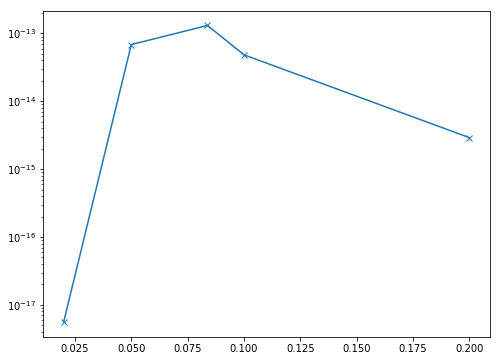

In [73]:
fig0 = plt.figure(figsize=(8,6))
plt.semilogy(var,evidenceSIR.mean(axis=0), '-x')
plt.show()